In [9]:
# Format Data for CNN and NN

import numpy as np
import os
import pickle
from utils import *
import torch

train_dir = 'FeaturesTrain'
# test_dir = 'FeatruesTest'


DATA = []
d = train_dir
for i in os.listdir(d):
    with open(os.path.join(d,i), 'rb') as f:
        DATA.append(pickle.load(f))


from sklearn.model_selection import train_test_split


x_keys = ['mfccCoeffs', 'chromaCoeffs','contrastCoeffs', 'tonnetz','melspectCoeffs']

Y = np.c_[[emotion_labels[i['emotion']] for i in DATA]].flatten()
X = np.c_[[np.concatenate([standard_scale[j](i[j]) for j in x_keys]).flatten() for i in DATA]]
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, stratify=Y)


from imblearn.over_sampling import RandomOverSampler 

idxs = np.arange(len(x_train)).reshape(-1,1)
ros = RandomOverSampler(random_state=42)
rs_idx, y_idx = ros.fit_resample(idxs, y_train)
rs_idx = rs_idx.flatten()
x_train = x_train[rs_idx]
y_train = y_train[rs_idx]


# from torch.utils.data import Dataset, DataLoader
# AD_train = AudioData(x_train, y_train)
# AD_val = AudioData(x_val, y_val)

# trainloader = DataLoader(AD_train, batch_size=8, shuffle=True)
# valloader = DataLoader(AD_val, batch_size=8, shuffle=True)


# device = torch.device('cpu')

In [11]:
X.shape

(1200, 141860)

In [12]:
from sklearn.linear_model import LogisticRegression

# backwards selection 
import time
from sklearn.model_selection import cross_val_score
import warnings
CVS = []
LR = LogisticRegression(C=0.001)

t1 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    CVS.append(cross_val_score(LR, X, Y, cv=5, n_jobs=5))
print(f'Full model: {time.time()-t1:.4f}')
        
rm_ids = []
for i in range(4):
    t1 = time.time()
    
    step_score = []
    for rm_key in x_keys:
        X = np.c_[[np.concatenate([standard_scale[j](i[j]) for j in np.setdiff1d(x_keys, rm_key)]).flatten() for i in DATA]]
#         X = np.c_[[np.concatenate([((i[j]-i[j].mean())/i[j].std()).flatten() for j in np.setdiff1d(x_keys, rm_key)]) for i in DATA]]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            step_score.append(cross_val_score(LR, X, Y, cv=5, n_jobs=5))

    scores = [i.mean() for i in step_score]
    rm_id = np.argmax(scores)
    CVS.append(step_score[rm_id])
    x_keys = np.setdiff1d(x_keys, x_keys[rm_id])
    rm_ids.append(rm_id)
    print(f'Step {i+1}: {time.time()-t1:.4f}')


Full model: 49.2774
Step 1: 205.1482
Step 2: 149.9872
Step 3: 21.9429
Step 4: 8.1614


/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

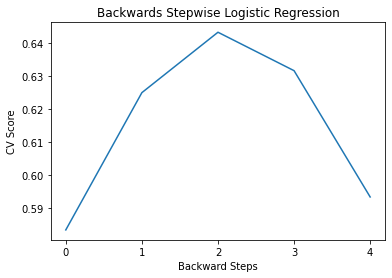

In [13]:
import matplotlib.pyplot as plt
cv_scores = [i.mean() for i in CVS]


plt.plot(np.arange(0,5), cv_scores)
plt.ylabel('CV Score')
plt.xlabel('Backward Steps')
plt.xticks(np.arange(0,5))
plt.title('Backwards Stepwise Logistic Regression')
plt.show()

In [37]:
x_keys = ['mfccCoeffs', 'chromaCoeffs','contrastCoeffs', 'tonnetz','melspectCoeffs']

for i in np.array(rm_ids)[:np.argmax(cv_scores)]:
    x_keys = np.delete(x_keys, i)
    
X = np.c_[[np.concatenate([standard_scale[j](i[j]) for j in x_keys]).flatten() for i in DATA]]

In [38]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000]}

LR = LogisticRegression()
GS = GridSearchCV(LR, parameters, cv=5, n_jobs=10)
GS.fit(X,Y)

/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=10,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000,
                               10000]})

In [39]:
print(GS.best_params_)
print(GS.best_score_)



{'C': 0.001}
0.5983333333333334


In [40]:
x_train, x_val, y_train, y_val = train_test_split(X,Y, train_size=0.8)

LR = LogisticRegression(C=GS.best_score_)
LR.fit(x_train, y_train)


from sklearn.metrics import confusion_matrix
pred = LR.predict(x_val)
cm = confusion_matrix(y_val, pred)

print(cm)
print(cm/cm.sum(1).reshape(-1,1))
print(f'Score: {LR.score(x_val, y_val)}')

[[25  1  6  1  2  0  0  4]
 [ 1 21  0  0  3  1  6  0]
 [ 1  1 20  3  0  1  2  1]
 [ 0  1  2 19  0  0  2  3]
 [ 3  0  0  4 17  2  3  4]
 [ 1  4  0  0  1  7  0  2]
 [ 0  5  1  1  5  5 21  0]
 [ 2  0  1  3  0  0  2 19]]
[[0.64102564 0.02564103 0.15384615 0.02564103 0.05128205 0.
  0.         0.1025641 ]
 [0.03125    0.65625    0.         0.         0.09375    0.03125
  0.1875     0.        ]
 [0.03448276 0.03448276 0.68965517 0.10344828 0.         0.03448276
  0.06896552 0.03448276]
 [0.         0.03703704 0.07407407 0.7037037  0.         0.
  0.07407407 0.11111111]
 [0.09090909 0.         0.         0.12121212 0.51515152 0.06060606
  0.09090909 0.12121212]
 [0.06666667 0.26666667 0.         0.         0.06666667 0.46666667
  0.         0.13333333]
 [0.         0.13157895 0.02631579 0.02631579 0.13157895 0.13157895
  0.55263158 0.        ]
 [0.07407407 0.         0.03703704 0.11111111 0.         0.
  0.07407407 0.7037037 ]]
Score: 0.6208333333333333


/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## retrain LR with all data


In [47]:
LR = LogisticRegression(**GS.best_params_)
LR.fit(X, Y)


/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.001)

In [51]:
import pickle


save = {'keys': x_keys,
        'model': LR}

with open('models/LogisticRegression.pkl', 'wb') as f:
    pickle.dump(save, f)
    